In [ ]:
#|default_exp asink

# The async version

## Setup

In [ ]:
#| export
import inspect, typing, mimetypes, base64, json
from collections import abc

from anthropic import AsyncAnthropic
from anthropic.types import ToolUseBlock
from toolslm.funccall import get_schema, mk_ns, call_func, call_func_async
from fastcore.meta import delegates
from fastcore.utils import *
from claudette.core import *
from msglm import mk_msg_anthropic as mk_msg, mk_msgs_anthropic as mk_msgs

In [ ]:
#| hide
from nbdev import show_doc

In [ ]:
from IPython.display import display,Image

## Async SDK

In [ ]:
model = models[1]
cli = AsyncAnthropic()

In [ ]:
prompt = "I'm Jeremy"
m = mk_msg(prompt)
r = await cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Hello Jeremy! Nice to meet you. How can I help you today?

<details>

- id: `msg_01WSoScnCMw2HpwQuNEkGpaw`
- content: `[{'citations': None, 'text': 'Hello Jeremy! Nice to meet you. How can I help you today?', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 18, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
msgs = mk_msgs([prompt, r, "I forgot my name. Can you remind me please?"]) 
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text='Hello Jeremy! Nice to meet you. How can I help you today?', type='text')]},
 {'role': 'user', 'content': 'I forgot my name. Can you remind me please?'}]

In [ ]:
await cli.messages.create(messages=msgs, model=model, max_tokens=200)

Of course! Your name is Jeremy.

<details>

- id: `msg_01M6s6n5jPHq8fe4zkopaisc`
- content: `[{'citations': None, 'text': 'Of course! Your name is Jeremy.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 42, 'output_tokens': 11, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
#| exports
class AsyncClient(Client):
    def __init__(self, model, cli=None, log=False, cache=False):
        "Async Anthropic messages client."
        super().__init__(model,cli,log,cache)
        if not cli: self.c = AsyncAnthropic(default_headers={'anthropic-beta': 'prompt-caching-2024-07-31'})

In [ ]:
c = AsyncClient(model)

In [ ]:
c._r(r)
c.use

In: 10; Out: 18; Cache create: 0; Cache read: 0; Total Tokens: 28; Search: 0

In [ ]:
#| exports
@asave_iter
async def _astream(o, cm, prefill, cb):
    async with cm as s:
        yield prefill
        async for x in s.text_stream: yield x
        o.value = await s.get_final_message()
        await cb(o.value)

In [ ]:
#| exports
@patch
@delegates(Client)
async def __call__(self:AsyncClient,
             msgs:list, # List of messages in the dialog
             sp='', # The system prompt
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             maxthinktok=0, # Maximum thinking tokens
             prefill='', # Optional prefill to pass to Claude as start of its response
             stream:bool=False, # Stream response?
             stop=None, # Stop sequence
             tools:Optional[list]=None, # List of tools to make available to Claude
             tool_choice:Optional[dict]=None, # Optionally force use of some tool
             cb=None, # Callback to pass result to when complete
             **kwargs):
    "Make an async call to Claude."
    msgs,kwargs = self._precall(msgs, prefill, sp, temp, maxtok, maxthinktok, stream,
                                stop, tools, tool_choice, kwargs)
    m = self.c.messages
    f = m.stream if stream else m.create
    res = f(model=self.model, messages=msgs, **kwargs)
    async def _cb(v):
        self._log(v, prefill=prefill, msgs=msgs, **kwargs)
        if cb: await cb(v)
    if stream: return _astream(res, prefill, _cb)
    res = await res
    try: return res
    finally: await _cb(res)

In [ ]:
c = AsyncClient(model, log=True)
c.use

In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Search: 0

In [ ]:
c.model = models[1]
await c('Hi')

Hello! How can I help you today?

<details>

- id: `msg_01QrsbLFyNfSdHD5u3m8T8qE`
- content: `[{'citations': None, 'text': 'Hello! How can I help you today?', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 8, 'output_tokens': 12, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
c.use

In: 8; Out: 12; Cache create: 0; Cache read: 0; Total Tokens: 20; Search: 0

In [ ]:
q = "Very concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'
await c(q, prefill=pref)

According to Douglas Adams,  it's 42.

More seriously: Create meaning through connections, growth, and contribution to something beyond yourself.

<details>

- id: `msg_01XaJGwfM8wwKn3GvByAMa6Y`
- content: `[{'citations': None, 'text': "According to Douglas Adams,  it's 42.\n\nMore seriously: Create meaning through connections, growth, and contribution to something beyond yourself.", 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 24, 'output_tokens': 27, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
c.use

In: 32; Out: 39; Cache create: 0; Cache read: 0; Total Tokens: 71; Search: 0

In [ ]:
r = await c(q, prefill=pref, stream=True)
async for o in r: print(o, end='')
r.value

According to Douglas Adams,  it's 

42.

More seriously: Create meaning through connections,

 growth, and contribution to something beyond yourself.

According to Douglas Adams,  it's 42.

More seriously: Create meaning through connections, growth, and contribution to something beyond yourself.

<details>

- id: `msg_01Svm4SGJ9dUBVFxHuKrTzev`
- content: `[{'citations': None, 'text': "According to Douglas Adams,  it's 42.\n\nMore seriously: Create meaning through connections, growth, and contribution to something beyond yourself.", 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 24, 'output_tokens': 27, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
c.use

In: 56; Out: 66; Cache create: 0; Cache read: 0; Total Tokens: 122; Search: 0

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
sp = "You are a summing expert."

In [ ]:
tools=[sums]
choice = mk_tool_choice('sums')
choice

{'type': 'tool', 'name': 'sums'}

In [ ]:
msgs = mk_msgs(pr)
r = await c(msgs, sp=sp, tools=tools, tool_choice=choice)
r

ToolUseBlock(id='toolu_01TKnF1t9kRoGDwTPUYUnwpS', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_01UtME5uDv4RamrTZr8HB7Vv`
- content: `[{'id': 'toolu_01TKnF1t9kRoGDwTPUYUnwpS', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 712, 'output_tokens': 57, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
#| export
async def mk_funcres_async(fc, ns):
    "Given tool use block `fc`, get tool result, and create a tool_result response."
    res = await call_func_async(fc.name, fc.input, ns=ns, raise_on_err=False)
    return dict(type="tool_result", tool_use_id=fc.id, content=str(res))

In [ ]:
#| export
async def mk_toolres_async(
    r:abc.Mapping, # Tool use request response from Claude
    ns:Optional[abc.Mapping]=None # Namespace to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    cts = getattr(r, 'content', [])
    res = [mk_msg(r.model_dump(), role='assistant')]
    if ns is None: ns=globals()
    tcs = [await mk_funcres_async(o, ns) for o in cts if isinstance(o,ToolUseBlock)]
    if tcs: res.append(mk_msg(tcs))
    return res

In [ ]:
tr = await mk_toolres_async(r, ns=globals())
tr

Finding the sum of 604542 and 6458932


[{'role': 'assistant',
  'content': [{'id': 'toolu_01TKnF1t9kRoGDwTPUYUnwpS',
    'input': {'a': 604542, 'b': 6458932},
    'name': 'sums',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01TKnF1t9kRoGDwTPUYUnwpS',
    'content': '7063474'}]}]

In [ ]:
msgs += tr
r = contents(await c(msgs, sp=sp, tools=sums))
r

'The sum of 604542 + 6458932 = **7,063,474**'

## Structured Output

In [ ]:
#|export
@patch
@delegates(Client.__call__)
async def structured(self:AsyncClient,
               msgs:list, # List of messages in the dialog
               tools:Optional[list]=None, # List of tools to make available to Claude
               ns:Optional[abc.Mapping]=None, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    tools = listify(tools)
    if ns is None: ns=mk_ns(*tools)
    res = await self(msgs, tools=tools, tool_choice=tools,**kwargs)
    cts = getattr(res, 'content', [])
    tcs = [await call_func_async(o.name, o.input, ns=ns) for o in cts if isinstance(o,ToolUseBlock)]
    return tcs

In [ ]:
await c.structured(pr, sums)

Finding the sum of 604542 and 6458932


[7063474]

In [ ]:
c

ToolUseBlock(id='toolu_01HfWqUFm529AfFNnNx3U7FD', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 2,180 | 0.006540 |
| Output tokens | 204 | 0.003060 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **2,384** | **$0.009600** |

## AsyncChat

In [ ]:
#| exports
@delegates()
class AsyncChat(Chat):
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 **kwargs):
        "Anthropic async chat client."
        super().__init__(model, cli, **kwargs)
        if not cli: self.c = AsyncClient(model)

In [ ]:
sp = "Always use tools if available, and calculations are requested."
chat = AsyncChat(model, sp=sp)
chat.c.use, chat.h

(In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Search: 0, [])

In [ ]:
#| exports
@patch
async def _append_pr(self:AsyncChat, pr=None):
    prev_role = nested_idx(self.h, -1, 'role') if self.h else 'assistant' # First message should be 'user' if no history
    if pr and prev_role == 'user': await self()
    self._post_pr(pr, prev_role)

In [ ]:
#| exports
@patch
async def __call__(self:AsyncChat,
                   pr=None,  # Prompt / message
                   temp=None, # Temperature
                   maxtok=4096, # Maximum tokens
                   maxthinktok=0, # Maximum thinking tokens
                   stream=False, # Stream response?
                   prefill='', # Optional prefill to pass to Claude as start of its response
                   tool_choice:Optional[Union[str,bool,dict]]=None, # Optionally force use of some tool
                   **kw):
    if temp is None: temp=self.temp
    await self._append_pr(pr)
    async def _cb(v):
        self.last = await mk_toolres_async(v, ns=self.ns)
        self.h += self.last
    return await self.c(self.h, stream=stream, prefill=prefill, sp=self.sp, temp=temp, maxtok=maxtok, maxthinktok=maxthinktok, tools=self.tools, tool_choice=tool_choice, cb=_cb, **kw)

In [ ]:
await chat("I'm Jeremy")
await chat("What's my name?")

Your name is Jeremy! You told me that at the start of our conversation.

<details>

- id: `msg_01V997mDpucmU87zhnF5dydS`
- content: `[{'citations': None, 'text': 'Your name is Jeremy! You told me that at the start of our conversation.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 47, 'output_tokens': 19, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
q = "Very concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'
await chat(q, prefill=pref)

According to Douglas Adams,  it's 42. 

More seriously: to find purpose through connection, growth, and contributing something meaningful to others.

<details>

- id: `msg_01HLoW2YqZkemPeqQGgrTqxN`
- content: `[{'citations': None, 'text': "According to Douglas Adams,  it's 42. \n\nMore seriously: to find purpose through connection, growth, and contributing something meaningful to others.", 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 86, 'output_tokens': 29, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat = AsyncChat(model, sp=sp)
r = await chat("I'm Jeremy", stream=True)
async for o in r: print(o, end='')
r.value

Hello Jeremy!

 Nice to meet you. How can I help you today?

Hello Jeremy! Nice to meet you. How can I help you today?

<details>

- id: `msg_01AggZKp4AKoGg7dzBE2qREi`
- content: `[{'citations': None, 'text': 'Hello Jeremy! Nice to meet you. How can I help you today?', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 21, 'output_tokens': 18, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
pr = f"What is {a}+{b}?"
chat = AsyncChat(model, sp=sp, tools=[sums])
r = await chat(pr)
r

Finding the sum of 604542 and 6458932


ToolUseBlock(id='toolu_01JqWJBzKkm78XjarRXvCy9W', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_01MokGeSj7HcFxZMsmDPk674`
- content: `[{'id': 'toolu_01JqWJBzKkm78XjarRXvCy9W', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 624, 'output_tokens': 72, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
await chat()

The sum of 604542 + 6458932 = **7,063,474**

<details>

- id: `msg_015ZSkMnf9gBRUf2u6mQz1VZ`
- content: `[{'citations': None, 'text': 'The sum of 604542 + 6458932 = **7,063,474**', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 712, 'output_tokens': 24, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

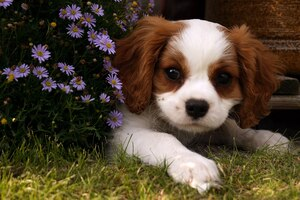

In [ ]:
fn = Path('samples/puppy.jpg')
img = fn.read_bytes()
Image(img)

In [ ]:
q = "In brief, what color flowers are in this image?"
msg = mk_msg([img, q])
await c([msg])

The flowers in this image are **purple**.

<details>

- id: `msg_01JN8RWq8Mhwkukqg9pwFxpa`
- content: `[{'citations': None, 'text': 'The flowers in this image are **purple**.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 110, 'output_tokens': 12, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Add `cache=True` to automatically add to Claude's KV cache.

In [ ]:
chat = AsyncChat(model, sp=sp, cache=True)
await chat("Lorem ipsum dolor sit amet" * 150)

I notice you've sent me the phrase "Lorem ipsum dolor sit amet" repeated many times. "Lorem ipsum" is placeholder text commonly used in design and publishing to demonstrate visual form without meaningful content.

Is there something specific I can help you with? For example:
- Do you have a question or task you'd like assistance with?
- Were you testing something?
- Did you mean to send different content?

I'm here to help with a wide range of tasks including answering questions, analysis, writing, problem-solving, and more. Please let me know what you need!

<details>

- id: `msg_01NyGkjEfKDhBEjDVjYALzXX`
- content: `[{'citations': None, 'text': 'I notice you\'ve sent me the phrase "Lorem ipsum dolor sit amet" repeated many times. "Lorem ipsum" is placeholder text commonly used in design and publishing to demonstrate visual form without meaningful content.\n\nIs there something specific I can help you with? For example:\n- Do you have a question or task you\'d like assistance with?\n- Were you testing something?\n- Did you mean to send different content?\n\nI\'m here to help with a wide range of tasks including answering questions, analysis, writing, problem-solving, and more. Please let me know what you need!', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 1063}, 'cache_creation_input_tokens': 1063, 'cache_read_input_tokens': 0, 'input_tokens': 3, 'output_tokens': 125, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use

In: 3; Out: 125; Cache create: 1063; Cache read: 0; Total Tokens: 1191; Search: 0

In this followup call, nearly all the tokens are cached, so the only the new additional tokens are charged at the full rate.

In [ ]:
await chat("Whoops, sorry about that!")

No problem at all! These things happen. 😊

How can I help you today? Feel free to ask me anything or let me know what you're working on!

<details>

- id: `msg_01HQnPcituHpsSC5fsN6Qugq`
- content: `[{'citations': None, 'text': "No problem at all! These things happen. 😊\n\nHow can I help you today? Feel free to ask me anything or let me know what you're working on!", 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 136}, 'cache_creation_input_tokens': 136, 'cache_read_input_tokens': 1063, 'input_tokens': 3, 'output_tokens': 39, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use

In: 6; Out: 164; Cache create: 1199; Cache read: 1063; Total Tokens: 2432; Search: 0

## Extended Thinking

Let's call the model without extended thinking enabled. 

In [ ]:
chat = AsyncChat(model)
await chat("Write a sentence about Python!")

Python is a versatile, high-level programming language known for its clean syntax and readability, making it popular for everything from web development to data science and machine learning.

<details>

- id: `msg_01VrHou5ydkh9c3ypukvNoCA`
- content: `[{'citations': None, 'text': 'Python is a versatile, high-level programming language known for its clean syntax and readability, making it popular for everything from web development to data science and machine learning.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 13, 'output_tokens': 38, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Now, let's call the model with extended thinking enabled.

In [ ]:
r = await chat("Write a sentence about Python!", maxthinktok=1024)
r


Python's extensive standard library and vast ecosystem of third-party packages make it an excellent choice for beginners and experienced developers alike.

<details>
<summary>Thinking</summary>
The user is asking me to write another sentence about Python. I'll provide a different sentence this time to give them varied information.
</details>


<details>

- id: `msg_01BzPZRU8hp3x4Rrv5gQiRVQ`
- content: `[{'signature': 'ErMCCkYICRgCKkDkES/w96cekkCn0ELoX3z+fFhvFUpSKOz4rtski52b6YaZbiUX6VXwW10/l/ZWtAWBXX6fNJ1sS2fCG1iP4KKiEgy0cpkiDex1h/6N/cAaDLtJ/s8siMsHfZ+2kiIwF6B33yCXMmE9Io1fGIpq3GKUQ/7wJuL/6OWumsarW6Fk50cjQRiKi9b4+bkdYNf9KpoBlHSDyEd4IEFTqvz+3k+YmmZFD0cz/7CnZQvYC4FuLzLflDa+afAWOLQTxOTJEiCNXEthPEwBBkkFm/wjeITw5V4QUVbH8fAVOguFQlLh03vEUFeTcsJ5ZEhRBR11tcBXuRaKB55PEawKIMoS0tYRkIt0jcKOkwIgDXfFUl+w/K9PipK+m/uxTn6w91NWXSvvinycMiHN0KREFhgB', 'thinking': "The user is asking me to write another sentence about Python. I'll provide a different sentence this time to give them varied information.", 'type': 'thinking'}, {'citations': None, 'text': "Python's extensive standard library and vast ecosystem of third-party packages make it an excellent choice for beginners and experienced developers alike.", 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 88, 'output_tokens': 64, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
r.content

[ThinkingBlock(signature='ErMCCkYICRgCKkDkES/w96cekkCn0ELoX3z+fFhvFUpSKOz4rtski52b6YaZbiUX6VXwW10/l/ZWtAWBXX6fNJ1sS2fCG1iP4KKiEgy0cpkiDex1h/6N/cAaDLtJ/s8siMsHfZ+2kiIwF6B33yCXMmE9Io1fGIpq3GKUQ/7wJuL/6OWumsarW6Fk50cjQRiKi9b4+bkdYNf9KpoBlHSDyEd4IEFTqvz+3k+YmmZFD0cz/7CnZQvYC4FuLzLflDa+afAWOLQTxOTJEiCNXEthPEwBBkkFm/wjeITw5V4QUVbH8fAVOguFQlLh03vEUFeTcsJ5ZEhRBR11tcBXuRaKB55PEawKIMoS0tYRkIt0jcKOkwIgDXfFUl+w/K9PipK+m/uxTn6w91NWXSvvinycMiHN0KREFhgB', thinking="The user is asking me to write another sentence about Python. I'll provide a different sentence this time to give them varied information.", type='thinking'),
 TextBlock(citations=None, text="Python's extensive standard library and vast ecosystem of third-party packages make it an excellent choice for beginners and experienced developers alike.", type='text')]

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()